# Deep Learning on Graph Data:

In this presentation we use Tensorflow to detect fraudulent graph structures. 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
# import seaborn as sns
import itertools as it
import random, datetime

from scipy.misc import logsumexp

In [2]:
# create new session if we need it
sess = tf.Session()

In [50]:
def displayGraph(graph, title='', color_values = None):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    nx.draw_networkx_nodes(graph, pos, cmap=plt.cm.Blues, node_color = color_values, alpha=0.8)

    nx.draw_networkx_labels(graph,pos)
    plt.title(title)
    plt.show()
    
def save_graph(graph, title='', color_values = None, filename='graph.png'):
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    nx.draw_networkx_nodes(graph, pos, cmap=plt.cm.Blues, node_color = color_values, alpha=0.8)

    nx.draw_networkx_labels(graph,pos)
    plt.title(title)
    plt.savefig(filename)

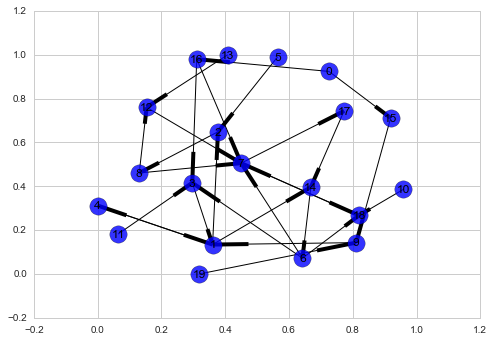

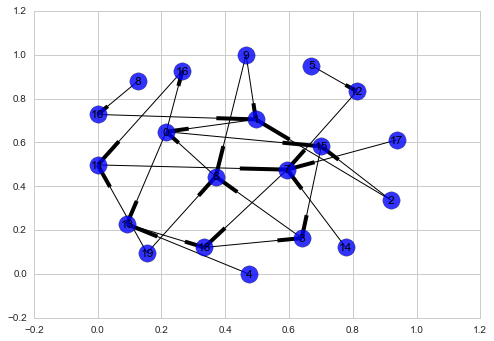

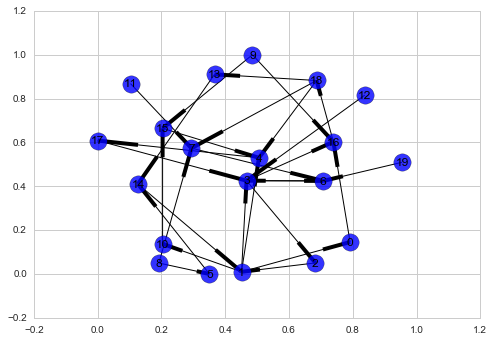

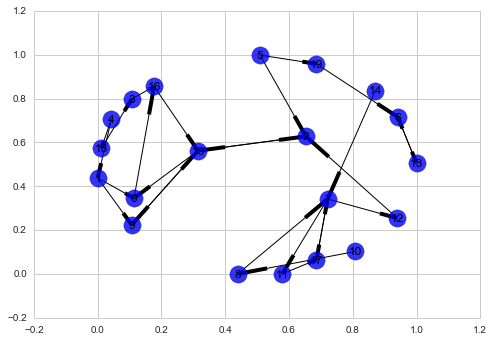

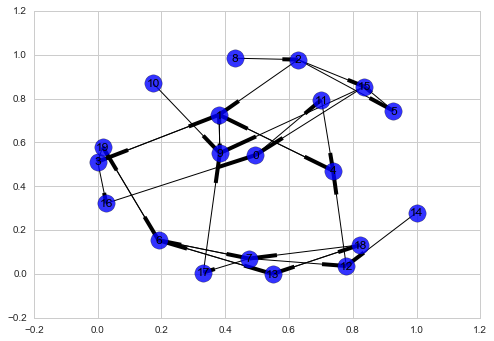

In [44]:
def generate_graphs(n, n_nodes=20, y=1):
    # Code to generate n random graphs
    
    graphset = []
    
    for i in range(n):
        
        random.seed(datetime.datetime.now())

        # Assigning number of nodes randomly between 1-200
#         n_nodes = random.randint(min_nodes,max_nodes)
        
        # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
        p = 0.2       
        m = 20
        s = 0.25

        graph = nx.duplication_divergence_graph(n_nodes, p, 1)
#         G_rand = nx.gnr_graph(n_nodes,p)
#         G_rand = nx.powerlaw_cluster_graph(n_nodes,4,0.1)
#         G_rand = nx.gnc_graph(n_nodes)
#         G_rand = nx.scale_free_graph(n_nodes)
#         G_rand = nx.DiGraph(G_rand)

        graph = graph.to_directed()
        
        random.seed(datetime.datetime.now())

        e_to_remove = []
        for e in graph.edges_iter():
            if random.random() > 0.4:
                e_to_remove.append(e)
                
        for e in e_to_remove:
            graph.remove_edge(e[0], e[1])

        
    
        # make sure all nodes have outdegree of at least 1
        outds = graph.out_degree().values()
        for i, outd in enumerate(outds):
            if outd == 0 or random.random() > 0.7:
                valid_inds = range(0,i) +\
                                    range(i+1,n_nodes)
#                 print i, valid_inds
                graph.add_edge(i, 
                                random.choice(valid_inds))

        graphset.append(graph)
    
    return graphset

example = generate_graphs(5)
for g in example:
#     print g.out_degree().values()
    v = np.ones((20,))*100
    displayGraph(g)

In [5]:
def pageRank_allocation(G):
    
    # Calculate PageRank here
    pr = nx.pagerank(G)
    
    # Assign PageRank values here
    for i in G:
        node = G.node[i]
        page_rank_value = pr[i]
        node['PageRank'] = tf.constant(page_rank_value)
        node['pr'] = pr[i]
    return pr.values()

In [6]:
# At this stage you have a list of Graphs containing random nodes from 1-200
# Each node has a tensorFlow constant value attached to it signifying its PageRank score

# first calc K, A, M
def pagerank(graph, damping=0.85):
    N = nx.number_of_nodes(graph)
    A = np.array(nx.to_numpy_matrix(graph))
    k = graph.out_degree().values()
    K = np.diag(k)
    M = (np.matmul(np.linalg.inv(K),A)).T
    R = np.matmul(np.linalg.inv(np.identity(N) - damping*M),\
        (1.0 - damping)/N * np.ones((N,1)))
    
#     for i in graph.node:
#         print R[i], graph.node[i]['pr']
    return R
    

    
# pagerank(generate_graphs)

In [14]:
def gen_test1():
    n = 20
    graphs = generate_graphs(n, n_nodes=20) 
    As = []
    ys = []
    ks = []
    
    prs = []
    scores = []
    for graph in graphs:
        pr = pageRank_allocation(graph)
        prs.append(pr)
        scores.append(np.max(np.array(pr)))
    
    scores_sorted = sorted(scores)
    real_threshold = scores_sorted[-4]
    print 'real threshold: ', real_threshold
        
    for i, graph in enumerate(graphs):
        if scores[i] > real_threshold:
            ys.append(1)
        else:
            ys.append(-1)
        
        
        As.append(nx.to_numpy_matrix(graph))
        ks.append(graph.out_degree().values())
        
    return As, ys, ks, graphs, prs, scores, real_threshold
        
As, ys, ks, graphs, prs, scores, real_threshold = gen_test1()


real threshold:  0.215048937519


In [15]:
def tf_pagerank(n, damping=0.85):
    d = tf.constant(damping)
    N = tf.constant(n, dtype=tf.float32)
    A = tf.placeholder(tf.float32, shape=(n,n))
    k = tf.placeholder(tf.float32, shape=(n,))
    kinv = tf.div(tf.ones((n,), tf.float32), k)
    Kinv = tf.diag(kinv)
    I2 = tf.eye(n)
    M = tf.transpose(tf.matmul(Kinv, A))
    Minv = tf.matrix_inverse(I2 - d*M)
    R = tf.matmul(Minv,\
        tf.multiply((1.0 - damping)/N, tf.ones((n,1))))
    
    return R, A, k

In [16]:
def opt_pgrank(As, ys, ks, epochs = 4):
    thresh = tf.Variable(0.0, name='threshold')
    R, A, k = tf_pagerank(20)
    y = tf.placeholder(tf.float32, shape=())
    
    cost = tf.nn.relu(tf.multiply(y, (thresh - tf.reduce_max(R))))
    
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    trainer = optimizer.minimize(cost)
    
    # get things ready
    sess.run(tf.global_variables_initializer())
    
    loss_hist = []
    thresh_hist = []
    y_hist = []
    for epoch in range(epochs):
        for i in range(len(ys)):
            sess.run(trainer, feed_dict={A : As[i], y : ys[i], k : ks[i]})
            loss_hist.append(sess.run(cost, feed_dict={A : As[i], y : ys[i], k : ks[i]}))
            thresh_hist.append(sess.run(thresh, feed_dict={A : As[i], y : ys[i], k : ks[i]}))
            y_hist.append(ys[i])
    
    return thresh_hist, loss_hist, y_hist
    

        
thresh_hist, loss_hist, y_hist = opt_pgrank(As, ys, ks)
learned_threshold = thresh_hist[-1]

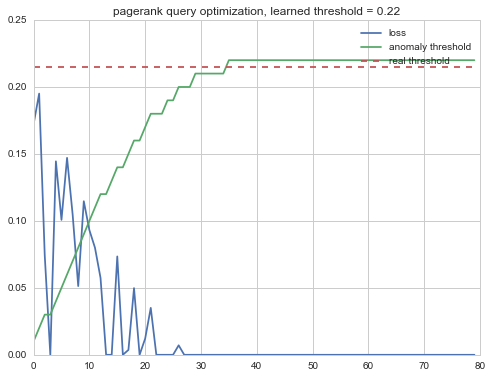

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
plt.plot(loss_hist)
plt.plot(thresh_hist)
plt.plot(np.ones((len(thresh_hist),))*real_threshold, '--')
plt.title('pagerank query optimization, learned threshold = '+str(learned_threshold))
plt.legend(['loss', 'anomaly threshold', 'real threshold'])
plt.show()

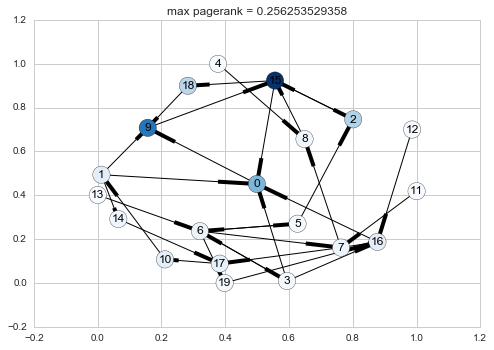

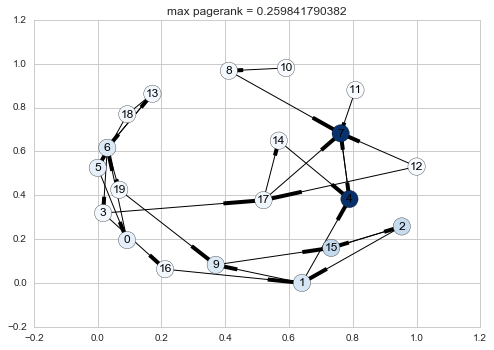

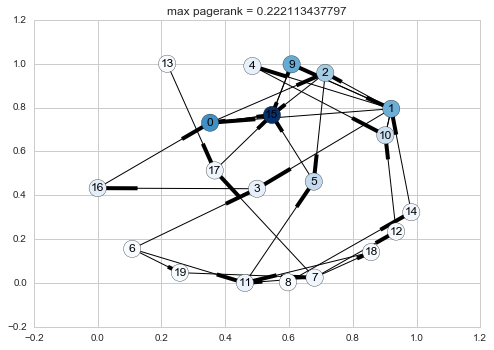

In [21]:
# plot anomolous graphs:
for graph in graphs:
    pr = pagerank(graph)
    pr = pr.flatten()
    pr_max = np.max(pr)
    if (pr_max > learned_threshold):
        displayGraph(graph, 'max pagerank = '+str(pr_max), pr)


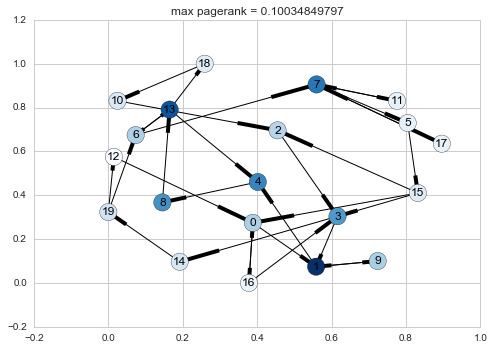

In [24]:
# show graph min max pagerank
min_pr_ind = np.argmin(scores)
displayGraph(graphs[min_pr_ind], 'max pagerank = '+str(scores[min_pr_ind]), prs[min_pr_ind])

mkdir: figs: File exists


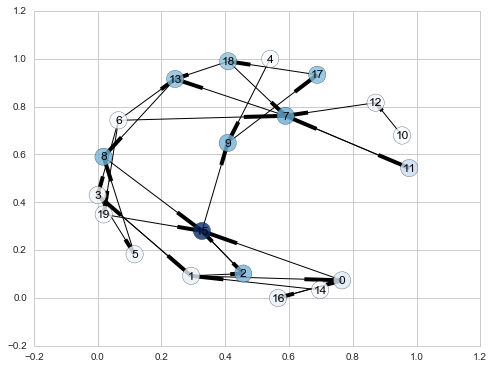

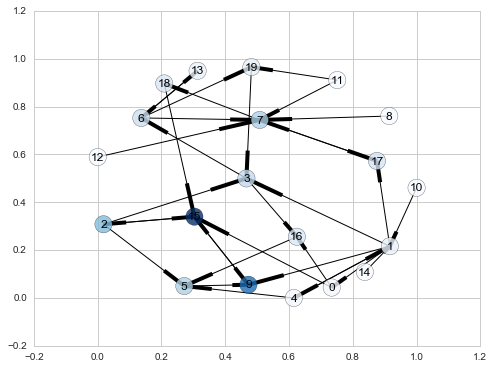

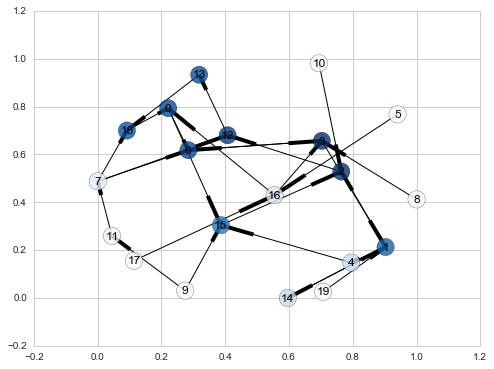

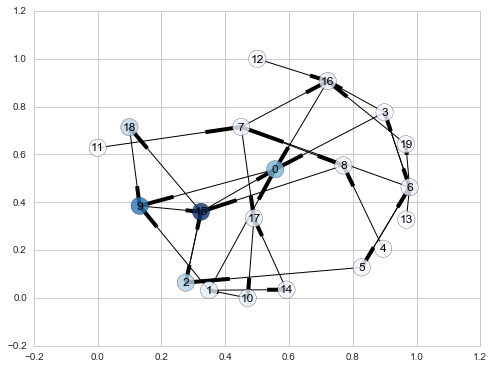

In [51]:
# plot some samples:
%mkdir figs
for i, g in enumerate(graphs[:4]):
    save_graph(g, '', prs[i], 'figs/ex_graph_'+str(i)+'.png')